# 재무제표를 이용한 분석

In [137]:
import pandas as pd
import datetime
import time
import requests
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.as_node_interactivity = "all"

# 데이터 저장 폴더
root_dir = "./csv/bs_analysis/"

start = time.time()
df_jongmok = pd.read_csv(f"./csv/jongmok_list.csv", encoding="euc-kr")[["단축코드", "한글 종목약명"]]
df_jongmok = df_jongmok.rename(columns={"단축코드":"CD", "한글 종목약명":"NM"})
# 데이터 프레임에 적용할 컬럼 정의
list_columns = [
    "DT", "CD", "NM", "ROE", "PER", "PBR", "PROFIT", "INCOME", 
    "FRGN_RT", "END_PRC", "VOL", "PRC_AVG_5", "VOL_AVG_5", "PRC_AVG_10", "VOL_AVG_10", "PRC_MEDIAN", "VOL_MEDIAN", 
    "REMAIN_SELL", "REMAIN_BUY", "REMAIN_BUY_AMOUNT", "DAY_SUMMARY"
]
# 재무제표
list_balance = [
    "CD", "NM", "ROE", "PER", "PBR", "PROFIT", "INCOME"
]
# 일 거래 종합
list_day_summary = [
    "DT", "CD", "NM", 
    "FRGN_RT", 
    "END_PRC", "VOL", "PRC_AVG_5", "VOL_AVG_5", "PRC_AVG_10", "VOL_AVG_10", "PRC_MEDIAN", "VOL_MEDIAN", 
    "REMAIN_SELL", "REMAIN_BUY", "REMAIN_BUY_AMOUNT", "DAY_SUMMARY",
]


list_result = []
list_recent_data = []
list_no_data = []
dt = datetime.datetime.now().strftime("%Y-%m-%d")


def convert_type(df_base, col, as_type):
    df_base[col] = df_base[col].astype(as_type)
    return df_base


def get_day_summary(cd, nm):
    url = f"https://finance.naver.com/item/sise.naver?code={cd}"
    list_df = pd.read_html(url, encoding="euc-kr")
    
    df_deal_summary = list_df[1]

    dict_deal_sumamry = {}

    for idx in [3, 4, 5, 10]:
        dict_deal_sumamry[df_deal_summary.iloc[idx][2]] = df_deal_summary.iloc[idx][3]
        if idx == 10:
            dict_deal_sumamry[df_deal_summary.iloc[idx][0]] = df_deal_summary.iloc[idx][1]

    return dict_deal_sumamry
    

# 일 거래 종합 - 잔량
def get_remain_deal_amount(cd, nm):
    url = f"https://finance.naver.com/item/sise.naver?code={cd}"
    list_df = pd.read_html(url, encoding="euc-kr")
    
    remain_sell = list_df[3].iloc[0][0]
    remain_buy = list_df[3].iloc[0][2]
    
    # 매수 잔량 금액
    df_remain_vol = list_df[2]
    df_remain_vol = df_remain_vol.drop(columns=["Unnamed: 2"], axis=1)
    df_remain_vol = df_remain_vol.fillna(0)
    df_remain_vol["SUM_SELL"] = df_remain_vol["매도잔량"].astype(int) * df_remain_vol["매도호가"].astype(int)
    df_remain_vol["SUM_BUY"] = df_remain_vol["매수잔량"].astype(int) * df_remain_vol["매수호가"].astype(int)
    df_remain_vol.drop((df_remain_vol.index[df_remain_vol["SUM_SELL"] == 0]) & (df_remain_vol.index[df_remain_vol["SUM_BUY"] == 0]), inplace = True)
    df_remain_vol["NM"] = "SAMSUNG"
    df_grouped = df_remain_vol.groupby(["NM"]).agg({
        "SUM_SELL": "sum", "SUM_BUY": "sum",
    })
    df_grouped.columns = ["REMAIN_SELL_SUM", "REMAIN_BUY_SUM"]
    df_grouped = df_grouped.reset_index()
    df_grouped["REMAIN_GAP_BUY_AMOUNT"] = ((df_grouped["REMAIN_BUY_SUM"] - df_grouped["REMAIN_SELL_SUM"]) / 1000000).astype(int)

    remain_buy_amount = df_grouped.REMAIN_GAP_BUY_AMOUNT.values[0]

    return remain_sell, remain_buy, remain_buy_amount


# 일 거래 종합 - 외국인, 종가, 거래량
def get_day_info(cd, nm):
    
    # 그룹 함수 적용
    def get_grouped(df_base):
        grouped = df_base.groupby(["NM"]).agg({
            "종가": "mean", "거래량": "mean",
        })
        grouped.columns = ["PRC_AVG", "VOL_AVG",]
        grouped = grouped.reset_index()

        return grouped
    
    pg = 1
    headers = {
        "referer" : f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}",    
        "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" 
    }
    
    url = f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}"
    res = requests.get(url=url, headers=headers)      
    # Pandas : read_html() > table element 추출 가능
    df_data = pd.read_html(res.text)[0].dropna().set_index("날짜").reset_index()
    # 전일비에 부호 지정
    df_data['전일비'] = df_data.종가.diff(-1).fillna(0).astype(int)
    end_prc = int(df_data.iloc[0][1])
    vol = df_data.iloc[0][6]
    df_data["NM"] = nm
    # 5일평균, 10일 평균, 중위값,
    # prc_avg_5, prc_avg_10, vol_avg_5, vol_avg_10, prc_median, vol_median
    # 5일 평균
    df_grouped = get_grouped(df_data.head(5))
    prc_avg_5 = float(str(df_grouped["PRC_AVG"].iloc[0]))
    vol_avg_5 = float(str(df_grouped["VOL_AVG"].iloc[0]))
    # 10일 평균
    df_grouped = get_grouped(df_data)
    prc_avg_10 = float(str(df_grouped["PRC_AVG"].iloc[0]))
    vol_avg_10 = float(str(df_grouped["VOL_AVG"].iloc[0]))
    # 중앙 값
    prc_median = np.median(list(df_data["종가"]))
    vol_median = np.median(list(df_data["거래량"]))
    # 최근 10일 거래 데이터
    for col in df_data.columns:
        if (col == "NM") or (col == "날짜"): continue
        df_data = convert_type(df_data, col, as_type=int)
        
    list_row = df_data.values.tolist()
    for idx in range(len(list_row)):
        list_recent_data.append(list_row[idx])
    return end_prc, vol, prc_avg_5, vol_avg_5, prc_avg_10, vol_avg_10, prc_median, vol_median


# ROE 값이 기준값 이상인 것만 고른다
def get_roe_more_than_base(cd, nm):
    roe_base = 15.0
    url = f"https://finance.naver.com/item/main.naver?code={cd}"
    
    list_roe = []
    list_per = []
    list_pbr = []
    list_profit = []
    list_income = []
    
    try:
        list_df = pd.read_html(url, encoding="euc-kr")
        df_bs_sheet = list_df[3]
        df_bs_sheet = df_bs_sheet.fillna(0)
        
        roe = 0.0
        
        if ".03" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.03"][0])
            list_ym = ["2019.03","2020.03","2021.03"]
        elif ".06" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.06"][0])
            list_ym = ["2019.06","2020.06","2021.06"]
        elif ".09" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.09"][0])
            list_ym = ["2019.09","2020.09","2021.09"]
        else:
            try:
                roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
                list_ym = ["2018.12","2019.12","2020.12","2021.12(E)"]
            except:
                roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12"][0])
                list_ym = ["2019.12","2020.12","2021.12"]
    
        if roe >= roe_base:
            # 일 거래 종합
            end_prc, vol, prc_avg_5, vol_avg_5, prc_avg_10, vol_avg_10, prc_median, vol_median = get_day_info(cd, nm)
            dict_day_summary = get_day_summary(cd, nm)
            # df_recent_data = pd.concat(df_recent_data, df_data)
            # 일 거래 종합 - 잔량
            remain_sell, remain_buy, remain_buy_amount = get_remain_deal_amount(cd, nm)
            # 거래량
            list_deal_vol = list_df[0][2][0].split(" ")
            deal_volume = list_deal_vol[len(list_deal_vol)-1].replace(",","")
            # 외국인
            frgn_rt = float(list_df[6][1].iloc[2].replace("%", ""))
            # 데이터 생성
            for ym in list_ym:
                try:
                    list_roe.append(float(df_bs_sheet.iloc[5].loc["최근 연간 실적", ym][0]))
                    list_per.append(float(df_bs_sheet.iloc[10].loc["최근 연간 실적", ym][0]))
                    list_pbr.append(float(df_bs_sheet.iloc[12].loc["최근 연간 실적", ym][0]))
                    if type(df_bs_sheet.iloc[1].loc["최근 연간 실적", ym][0]) is str:
                        list_profit.append(int(df_bs_sheet.iloc[1].loc["최근 연간 실적", ym][0].replace(",", "")))
                    else:
                        list_profit.append(int(df_bs_sheet.iloc[1].loc["최근 연간 실적", ym][0]))
                    if type(df_bs_sheet.iloc[2].loc["최근 연간 실적", ym][0]) is str:
                        list_income.append(int(df_bs_sheet.iloc[2].loc["최근 연간 실적", ym][0].replace(",", "")))
                    else:
                        list_income.append(int(df_bs_sheet.iloc[2].loc["최근 연간 실적", ym][0]))
                except:
                    pass
            
            list_result.append([dt, "A" + cd, nm, 
                                list_roe, list_per, list_pbr, list_profit, list_income, 
                                frgn_rt, int(end_prc), int(vol), int(prc_avg_5), int(vol_avg_5), int(prc_avg_10), int(vol_avg_10), int(prc_median), int(vol_median), 
                                int(remain_sell), int(remain_buy), int(remain_buy_amount),
                                dict_day_summary
                               ])
    except Exception as e:
        list_no_data.append([cd, nm, e])
        
# get_roe_more_than_base("298540", "더네이쳐홀딩스")
# get_roe_more_than_base("000215", "DL우")
for index, row in df_jongmok.iterrows():
    get_roe_more_than_base(str(row.CD), row.NM)

# Today's dataframe
df_now = pd.DataFrame(data=list_result, columns=list_columns)
df_now[list_balance].to_csv(f"{root_dir}balance_sheet.csv", encoding="utf-8-sig", index=False)
# Day Summary Possesion
try:
    # Extract from yesterday csv file and make dataframe
    df_pre = pd.read_csv(f"{root_dir}day_summary.csv", encoding="utf-8-sig")
    df_result = pd.concat([df_now[list_day_summary], df_pre]).drop_duplicates()
    # Save result dataframe to csv file 
    df_result.to_csv(f"{root_dir}day_summary.csv", encoding="utf-8-sig", index=False)
# No previous data
except:
    df_now[list_day_summary].to_csv(f"{root_dir}day_summary.csv", encoding="utf-8-sig", index=False)
    
end = time.time()

print("#" * 100)
# 오류 데이터
df_no_data = pd.DataFrame(data=list_no_data, columns=["CD", "NM", "MESSAGE"])
df_no_data.to_csv(f"{root_dir}no_data.csv", encoding="utf-8-sig", index=False)
# 최근 10일 데이터
list_recent_columns=["날짜","종가","전일비","시가","고가","저가","거래량","NM"]
df_recent_data = pd.DataFrame(data=list_recent_data, columns=list_recent_columns)
df_recent_data.to_csv(f"{root_dir}recent_deal.csv", encoding="utf-8-sig", index=False)
# 결과
print(len(list_result), " 건")
print(f"Elapsed Seconds: {end - start}")

/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_1388/3147465988.py:136: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_1388/3147465988.py:139: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_1388/3147465988.py:156: PerformanceWarning: indexing past lexsort depth may impact performance.
  list_roe.append(float(df_bs_sheet.iloc[5].loc["최근 연간 실적", ym][0]))
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_1388/3147465988.py:157: PerformanceWarning: indexing past lexsort depth may impact performance.
  list_per.append(float(df_bs_sheet.iloc[10].loc["최근 연간 실적", ym][0]))
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_1388/3147465988.py:158: Perfo

####################################################################################################
277  건
Elapsed Seconds: 443.5208101272583


In [138]:
import pandas as pd

list_ordered_key = ["CD", "DT"]
list_using_columns = [
    "NM", "FRGN_RT", "END_PRC", "VOL", "REMAIN_SELL", "REMAIN_BUY",
    "PRC_AVG_5", "VOL_AVG_5", "PRC_AVG_10", "VOL_AVG_10", "PRC_MEDIAN", "VOL_MEDIAN"
]
# 외국인 보유비율
df_calc_base = pd.read_csv(f"{root_dir}day_summary.csv", encoding="utf-8-sig")[list_ordered_key + list_using_columns]
# 살려는 양이 더 많은지 확인을 위해
df_calc_base["REMAIN_GAP_BUY"] = df_calc_base["REMAIN_BUY"] - df_calc_base["REMAIN_SELL"]

df_calc_base = df_calc_base.sort_values(list_ordered_key)

def make_rising_dict(df_base, col, base_day):
    # 종목
    list_nm = df_base["NM"].unique()
    # 추세 딕셔너리
    dict_rising = {}
    # 딕셔너리 데이터 생성
    for nm in list_nm:
        dict_rising[nm] = list(df_base[df_base["NM"] == nm][["NM", col]].head(base_day).T.reset_index().loc[1])[1:]
    
    return dict_rising


# 처음 마지막 값
def make_first_last_value(df_base, col):
    df_first_last = df_base.groupby(["NM"]).agg(
        FIRST_VAL=(col, "first"), 
        LAST_VAL=(col, "last")).reset_index()

    df_first_last["GAP"] = df_first_last["LAST_VAL"] - df_first_last["FIRST_VAL"]
    df_first_last["GAP_RT"] = round((df_first_last["GAP"] / df_first_last["FIRST_VAL"]) * 100, 2)
    
    df_first_last = df_first_last.rename(
        columns={"FIRST_VAL": f"FIRST_{col}", "LAST_VAL": f"LAST_{col}"}
    )

    return df_first_last.sort_values(by=["GAP_RT"], ascending=False).fillna(0.0)

In [139]:
pg = 1
cd = "005930"
headers = {
    "referer" : f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}",    
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" 
}

url = f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}"
res = requests.get(url=url, headers=headers)      
# Pandas : read_html() > table element 추출 가능
df_data = pd.read_html(res.text)[0].dropna().set_index("날짜").reset_index()

df_data['전일비'] = df_data.종가.diff(-1).fillna(0).astype(int)
df_data

,날짜,종가,전일비,시가,고가,저가,거래량
0,2022.03.23,70500.0,200,70600.0,71200.0,70300.0,12332242.0
1,2022.03.22,70300.0,400,69900.0,70500.0,69900.0,9402666.0
2,2022.03.21,69900.0,-800,70900.0,71000.0,69900.0,11169002.0
3,2022.03.18,70700.0,-500,70600.0,70900.0,70200.0,14410038.0
4,2022.03.17,71200.0,800,71200.0,71800.0,70900.0,17646315.0
5,2022.03.16,70400.0,900,70200.0,70500.0,69700.0,10175750.0
6,2022.03.15,69500.0,-700,69800.0,70100.0,69500.0,10258562.0
7,2022.03.14,70200.0,200,70000.0,70200.0,69600.0,9040993.0
8,2022.03.11,70000.0,-1200,70500.0,70700.0,69700.0,15787655.0
9,2022.03.10,71200.0,0,70800.0,71200.0,70500.0,21159248.0


In [140]:
# 외국인 보유비율
col = "FRGN_RT"
# 정렬
df_frgn_rt = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_frgn_rt = make_rising_dict(df_frgn_rt, col, 5)
# 최초 마지막 값 구성
df_frgn_rt_calc = make_first_last_value(df_frgn_rt, col)

df_frgn_rt_calc

,NM,FIRST_FRGN_RT,LAST_FRGN_RT,GAP,GAP_RT
194,제놀루션,0.01,0.28,0.27,2700.00
140,아이비김영,0.05,0.32,0.27,540.00
13,HRS,0.11,0.39,0.28,254.55
245,피제이메탈,0.38,0.78,0.40,105.26
102,문배철강,0.34,0.69,0.35,102.94
...,...,...,...,...,...
178,이랜시스,0.19,0.04,-0.15,-78.95
18,KG동부제철우,0.00,0.00,0.00,0.00
36,SBS,0.00,0.00,0.00,0.00
54,금호건설우,0.00,0.00,0.00,0.00


In [141]:
# 종가
col = "END_PRC"
# 정렬
df_end_prc = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_end_prc = make_rising_dict(df_end_prc, col, 5)
# 최초 마지막 값 구성
df_end_prc_calc = make_first_last_value(df_end_prc, col)

# 최근 5일 종가 평균
df_end_prc_avg = make_first_last_value(df_end_prc, "PRC_AVG_5")[["NM", "LAST_PRC_AVG_5"]]
df_end_prc_calc = pd.merge(df_end_prc_calc, df_end_prc_avg, how="inner", on=["NM"])
# 최근 10일 종가 평균
df_end_prc_avg = make_first_last_value(df_end_prc, "PRC_AVG_10")[["NM", "LAST_PRC_AVG_10"]]
df_end_prc_calc = pd.merge(df_end_prc_calc, df_end_prc_avg, how="inner", on=["NM"])

df_end_prc_calc

,NM,FIRST_END_PRC,LAST_END_PRC,GAP,GAP_RT,LAST_PRC_AVG_5,LAST_PRC_AVG_10
0,문배철강,4585,5840,1255,27.37,4816,4585
1,매커스,9040,11350,2310,25.55,9252,8656
2,포스코강판,48400,57000,8600,17.77,49820,48330
3,한일철강,3790,4355,565,14.91,3828,3664
4,서울옥션,23000,25350,2350,10.22,23720,23090
...,...,...,...,...,...,...,...
277,HMM,32600,31200,-1400,-4.29,32290,32565
278,휠라홀딩스,33150,31550,-1600,-4.83,32730,33095
279,포인트모바일,19500,18450,-1050,-5.38,19330,19125
280,진흥기업우B,6940,6510,-430,-6.20,6908,6944


In [142]:
# 거래량
col = "VOL"
# 정렬
df_deal_vol = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_deal_vol = make_rising_dict(df_deal_vol, col, 5)
# 최초 마지막 값 구성
df_deal_vol_calc = make_first_last_value(df_deal_vol, col)

df_deal_vol_calc

,NM,FIRST_VOL,LAST_VOL,GAP,GAP_RT
118,삼현철강,89387,3708609,3619222,4048.94
102,문배철강,785001,24190906,23405905,2981.64
236,포스코강판,31148,775136,743988,2388.56
264,한양증권우,55,1314,1259,2289.09
30,NI스틸,347324,4334920,3987596,1148.09
...,...,...,...,...,...
153,에치에프알,356981,84943,-272038,-76.21
176,이녹스,170946,34283,-136663,-79.95
90,레이크머티리얼즈,2175183,382632,-1792551,-82.41
157,엠로,625735,84227,-541508,-86.54


In [143]:
# 거래 잔량
col = "REMAIN_GAP_BUY"
# 정렬
df_remain_gap_buy = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_remain_gap_buy = make_rising_dict(df_remain_gap_buy, col, 5)
# 최초 마지막 값 구성
df_remain_gap_buy_calc = make_first_last_value(df_remain_gap_buy, col)

df_remain_gap_buy_calc

,NM,FIRST_REMAIN_GAP_BUY,LAST_REMAIN_GAP_BUY,GAP,GAP_RT
255,한국기업평가,-3,-759,-756,25200.00
97,메가스터디교육,-9,-1917,-1908,21200.00
183,이엠텍,-763,-38892,-38129,4997.25
222,키움증권,253,9620,9367,3702.37
268,한화3우B,-168,-5075,-4907,2920.83
...,...,...,...,...,...
262,한양디지텍,3274,-45503,-48777,-1489.83
46,YG PLUS,-4022,77513,81535,-2027.23
175,이구산업,-877,17163,18040,-2057.01
88,디지털대성,-829,18930,19759,-2383.47


In [144]:
# 재무제표 선정 종목
df_balance = pd.read_csv(f"{root_dir}balance_sheet.csv", encoding="utf-8-sig")
# 대상 종목의 외국인 추세 추가
df_balance["FRGN_RT"] = df_balance["NM"].apply(lambda X: dict_frgn_rt[X])
# 종가 추세 추가
df_balance["END_PRC"] = df_balance["NM"].apply(lambda X: dict_end_prc[X])
# 거래량 추세 추가
df_balance["VOL"] = df_balance["NM"].apply(lambda X: dict_deal_vol[X])
# 잔량 추세 추가
df_balance["REMAIN_DEAL"] = df_balance["NM"].apply(lambda X: dict_remain_gap_buy[X])

# 가장 최근 중간 값 추출
df_recent_median = df_calc_base.groupby(["CD"]).agg(
    PRC_MEDIAN=("PRC_MEDIAN", "first"), 
    VOL_MEDIAN=("VOL_MEDIAN", "first")).reset_index()

# 이하 필터링 이전 데이터 옆으로 붙이기
# 중간 값
df_balance = pd.merge(
    df_balance, 
    df_recent_median[["CD", "PRC_MEDIAN", "VOL_MEDIAN"]], 
    how="inner", 
    on=["CD"])
# 마지막 외국인 지분율
df_balance = pd.merge(
    df_balance,
    df_frgn_rt_calc[["NM", "LAST_FRGN_RT"]],
    how="inner", 
    on=["NM"])
# 종가
df_balance = pd.merge(
    df_balance,
    df_end_prc_calc[["NM", "LAST_END_PRC", "LAST_PRC_AVG_5", "LAST_PRC_AVG_10"]],
    how="inner", 
    on=["NM"])
# 거래량
df_balance = pd.merge(
    df_balance,
    df_deal_vol_calc[["NM", "LAST_VOL"]],
    how="inner", 
    on=["NM"])
# 거랭 잔량
df_balance = pd.merge(
    df_balance,
    df_remain_gap_buy_calc[["NM", "LAST_REMAIN_GAP_BUY"]],
    how="inner", 
    on=["NM"])

df_balance

,CD,NM,ROE,PER,PBR,PROFIT,INCOME,FRGN_RT,END_PRC,VOL,REMAIN_DEAL,PRC_MEDIAN,VOL_MEDIAN,LAST_FRGN_RT,LAST_END_PRC,LAST_PRC_AVG_5,LAST_PRC_AVG_10,LAST_VOL,LAST_REMAIN_GAP_BUY
0,A098120,마이크로컨텍솔,"[2.77, 3.32, 19.78]","[44.81, 45.82, 15.59]","[1.22, 1.49, 2.81]","[6, 17, 79]","[8, 11, 76]",[14.71],[10950],[78976],[-3069],10475,56974,14.71,10950,10710,10411,78976,-3069
1,A282330,BGF리테일,"[26.46, 18.6, 19.61]","[19.35, 19.09, 17.03]","[4.7, 3.36, 3.11]","[1966, 1622, 1994]","[1514, 1227, 1476]","[30.94, 30.94, 30.93]","[178000, 179000, 180000]","[35341, 28891, 32656]","[-4860, -2052, -4874]",174000,61437,30.93,180000,177900,175700,32656,-4874
2,A000995,DB하이텍1우,"[17.12, 17.39, 23.07, 31.18]","[5.56, 11.74, 13.67, 10.61]","[0.84, 1.86, 2.79, 2.81]","[1130, 1813, 2393, 3810]","[868, 1046, 1660, 2908]","[1.07, 1.07, 1.07]","[95000, 94800, 94100]","[143, 89, 90]","[17, -168, 36]",93750,274,1.07,94100,94220,93810,90,36
3,A000990,DB하이텍,"[17.12, 17.39, 23.07, 31.18]","[5.56, 11.74, 13.67, 10.61]","[0.84, 1.86, 2.79, 2.81]","[1130, 1813, 2393, 3810]","[868, 1046, 1660, 2908]","[23.88, 23.79, 23.79]","[72500, 72600, 74900]","[1502060, 655794, 1191182]","[49578, 15837, -72511]",69450,784288,23.79,74900,72660,70980,1191182,-72511
4,A000215,DL우,"[11.74, 11.84, 26.52]","[5.25, 6.34, 1.47]","[0.59, 1.24, 0.35]","[1360, 1190, 2219]","[7103, 5727, 8750]","[7.2, 7.2, 7.19]","[37550, 37650, 37650]","[1393, 945, 1773]","[-515, 214, -541]",36975,700,7.19,37650,37520,37215,1773,-541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,A298050,효성첨단소재,"[-19.74, 0.03, 54.69]","[-7.11, 8489.96, 10.65]","[1.53, 2.13, 4.41]","[1583, 342, 4373]","[-529, 68, 3300]","[7.59, 7.54, 7.57]","[489500, 489500, 489000]","[22744, 20673, 27882]","[1390, 2123, 1195]",492500,31186,7.57,489000,492700,490800,27882,1195
273,A298020,효성티앤씨,"[20.86, 25.1, 76.22]","[7.18, 6.68, 2.93]","[1.36, 1.52, 1.58]","[3229, 2666, 14237]","[1220, 1683, 10079]","[11.9, 11.69, 11.81]","[459000, 467500, 462500]","[59036, 26262, 39025]","[4283, 92, 4774]",478250,36263,11.81,462500,468800,473150,39025,4774
274,A298000,효성화학,"[21.37, -2.71, 15.58]","[5.25, -42.98, 13.75]","[1.01, 1.24, 1.92]","[1539, 609, 1486]","[878, -116, 704]","[7.27, 7.27, 7.27]","[256500, 257500, 256000]","[21361, 8573, 19777]","[3268, 2227, 978]",264250,13030,7.27,256000,259700,262150,19777,978
275,A081660,휠라홀딩스,"[16.03, 23.8, 10.94, 18.63]","[22.78, 12.14, 19.11, 7.23]","[3.3, 2.58, 2.03, 1.21]","[3571, 4707, 3411, 5193]","[2100, 3381, 1977, 3685]","[41.53, 41.43, 40.87]","[33150, 31600, 31550]","[332995, 975347, 512177]","[20030, 25316, 33078]",33675,340460,40.87,31550,32730,33095,512177,33078


In [145]:
import pandas as pd
import numpy as np
import statistics

# 데이터 저장 폴더
root_dir = "./csv/bs_analysis/"

# 리스트의 평균 추출
def get_avg_in_list(col):
    try:
        list_val = eval(col)
    except:
        list_val = col
    return round(statistics.mean(list_val), 2)

# 값 증가 여부 추가
def check_rising_list_val(col):
    try:
        list_val = eval(col)
    except:
        list_val = col
    
    if len(list_val) < 2:
        return "N"
    
    pre_val = 0
    for val in list_val:
        if pre_val == 0:
            pre_val = val
            continue
        elif val < pre_val:
            return "N"
        
        pre_val = val
            
    return "Y"


list_columns = [
    "CD", "NM",
    "LAST_FRGN_RT", "LAST_END_PRC", "PRC_MEDIAN", "LAST_PRC_AVG_5", "LAST_PRC_AVG_10",
    "LAST_VOL", "VOL_MEDIAN",
    "ROE", "ROE_AVG", "PER", "PBR", "PROFIT",
    "FRGN_RT", "END_PRC", "VOL", "REMAIN_DEAL"
]
dict_rename_cols = {
    "CD": "코드",
    "NM": "종목",
    "LAST_FRGN_RT": "최근 외국인 지분율",
    "LAST_END_PRC": "최근 종가", 
    "PRC_MEDIAN": "최근10일 종가 중간값", 
    "LAST_PRC_AVG_5": "최근5일 종가 평균", 
    "LAST_PRC_AVG_10": "최근10일 종가 평균",
    "LAST_VOL": "마지막 거래량", 
    "VOL_MEDIAN": "최근10일 거래량 중간값",
    "ROE": "자기자본이익률(ROE)", 
    "ROE_AVG": "ROE 평균", 
    "PER": "주가수익비율", 
    "PBR": "주가순자산비율", 
    "PROFIT": "영업이익",
    "FRGN_RT": "외국인지분율", 
    "END_PRC": "종가", 
    "VOL": "거래량", 
    "REMAIN_DEAL": "매수잔량",
}

# 계속 증가하는지 여부
# ROE
df_balance["RISING_ROE"] = df_balance["ROE"].apply(lambda X: check_rising_list_val(X))
# ROE 평균
df_balance["ROE_AVG"] = df_balance["ROE"].apply(lambda X: get_avg_in_list(X))
# 영업이익
df_balance["RISING_PROFIT"] = df_balance["PROFIT"].apply(lambda X: check_rising_list_val(X))
# 외국인
df_balance["RISING_FRGN_RT"] = df_balance["FRGN_RT"].apply(lambda X: check_rising_list_val(X))
# 매수 잔량
df_balance["RISING_REMAIN_DEAL"] = df_balance["REMAIN_DEAL"].apply(lambda X: check_rising_list_val(X))
# 종가가 기준(평균? 중간 값?) 이하인지
df_balance["PRC_BASE"] = np.where(df_balance["LAST_END_PRC"] < df_balance["PRC_MEDIAN"], "Y", "N")
# 거래량이 중간 값 이상인지
df_balance["VOL_BASE"] = np.where(df_balance["LAST_VOL"] > df_balance["VOL_MEDIAN"], "Y", "N")
# 매수 대기가 많은지
df_balance["REMAIN_GAP_BUY_BASE"] = np.where(df_balance["LAST_REMAIN_GAP_BUY"] > 0, "Y", "N")

# 최종 선택 종목
df_selected = df_balance[
    # 덜 중요한 순서
    # (df_balance["REMAIN_GAP_BUY_BASE"] == "Y") &
    # (df_balance["RISING_REMAIN_DEAL"] == "Y") &
    # (df_balance["PRC_BASE"] == "Y") &
    # (df_balance["VOL_BASE"] == "Y") &
    (df_balance["RISING_FRGN_RT"] == "Y") &
    # 이하 필수
    # ROE는 계속 증가, 15 이상이고 영업이익도 계속 증가하는 종목
    (df_balance["LAST_FRGN_RT"] > 4.99) &
    (df_balance["RISING_ROE"] == "Y") & 
    (df_balance["ROE_AVG"] > 14.99) & 
    (df_balance["RISING_PROFIT"] == "Y")
]

df_selected = df_selected[list_columns].sort_values(by=["ROE_AVG"], ascending=False).rename(columns=dict_rename_cols)
df_selected.to_csv(f"{root_dir}selected_target_{dt.replace('-','')}.csv", encoding="utf-8-sig", index=-False)
df_selected

,코드,종목,최근 외국인 지분율,최근 종가,최근10일 종가 중간값,최근5일 종가 평균,최근10일 종가 평균,마지막 거래량,최근10일 거래량 중간값,자기자본이익률(ROE),ROE 평균,주가수익비율,주가순자산비율,영업이익,외국인지분율,종가,거래량,매수잔량
37,A011780,금호석유,20.41,162500,151500,160100,156100,90197,117286,"[11.84, 20.18, 47.76]",26.59,"[8.81, 8.33, 2.83]","[0.82, 1.28, 0.92]","[3654, 7422, 24068]","[20.34, 20.37, 20.41]","[159500, 161500, 162500]","[122474, 89232, 90197]","[-17941, -28283, -32317]"
244,A166090,하나머티리얼즈,25.75,51200,50650,51540,50515,42411,87140,"[20.86, 22.82, 29.96]",24.55,"[13.45, 14.75, 18.54]","[2.53, 2.95, 4.77]","[409, 531, 823]","[25.64, 25.72, 25.75]","[51700, 51400, 51200]","[49120, 36434, 42411]","[2395, -2175, 6761]"
250,A002960,한국쉘석유,63.14,255000,251250,251300,251400,1775,1006,"[21.3, 21.44, 27.97]",23.57,"[19.97, 15.99, 11.52]","[4.29, 3.43, 3.06]","[257, 310, 380]","[63.13, 63.14]","[252000, 255000]","[497, 1775]","[1501, -117]"
254,A042700,한미반도체,5.76,33050,32450,32860,32430,143615,195082,"[8.85, 21.03, 34.59]",21.49,"[24.06, 18.76, 18.06]","[1.85, 3.46, 5.4]","[137, 666, 1224]","[5.73, 5.76, 5.76]","[33000, 33050, 33050]","[272678, 136742, 143615]","[7625, 11441, 725]"
74,A093520,매커스,14.45,11350,8135,9252,8656,5515426,139518,"[9.11, 14.57, 36.66]",20.11,"[12.7, 10.17, 5.2]","[0.92, 1.07, 1.21]","[59, 95, 260]","[13.85, 14.45]","[9040, 11350]","[490888, 5515426]","[-4737, -137585]"
266,A195870,해성디에스,6.64,50300,48450,49850,48475,78790,174772,"[9.06, 13.62, 27.09]",16.59,"[14.65, 13.83, 11.65]","[1.29, 1.79, 2.82]","[270, 435, 863]","[6.51, 6.62, 6.64]","[49800, 50200, 50300]","[114387, 89712, 78790]","[-10908, -18449, -2538]"
83,A214180,민앤지,12.79,18250,17500,17890,17665,38363,22381,"[14.79, 15.71, 15.9, 17.42]",15.96,"[16.33, 11.25, 11.62, 9.83]","[2.3, 1.57, 1.67, 1.59]","[260, 270, 282, 419]","[12.77, 12.77, 12.79]","[17450, 18000, 18250]","[48941, 39513, 38363]","[10727, -4333, -8039]"
224,A131290,티에스이,8.83,59500,58150,59020,58030,19537,44879,"[10.33, 15.12, 20.55]",15.33,"[9.44, 25.52, 18.23]","[0.86, 3.41, 3.27]","[207, 427, 546]","[8.75, 8.79, 8.83]","[58500, 59000, 59500]","[16291, 13925, 19537]","[649, 452, 2060]"
15,A011070,LG이노텍,25.55,398500,352000,393400,371400,459453,448834,"[4.73, 10.2, 30.94]",15.29,"[32.39, 18.29, 9.7]","[1.5, 1.78, 2.6]","[4764, 6810, 12642]","[24.57, 25.32, 25.55]","[405000, 411500, 398500]","[674862, 356758, 459453]","[1327, -345, 4905]"
219,A095610,테스,10.26,27150,24650,26510,25530,103565,90751,"[4.56, 13.3, 27.84]",15.23,"[50.68, 19.53, 7.95]","[2.23, 2.37, 1.87]","[117, 317, 622]","[9.92, 10.02, 10.26]","[26150, 27050, 27150]","[94254, 219278, 103565]","[-8687, -10859, -7733]"


In [147]:
df_result = df_selected[["종목", "최근 외국인 지분율", "최근 종가", "ROE 평균"]]

result = "####################################################" + "\n"
result += f"# 종목\t외국인지분율\t종가\tROE 평균" + "\n"
result += "####################################################" + "\n"
for idx, row in df_result.iterrows():
    print_val = f'# {row["종목"]}\t{row["최근 외국인 지분율"]}%\t{format(int(row["최근 종가"]), ",")}\t{row["ROE 평균"]}%\n'
    result += print_val
print(result)
# send_message_to_slack(result)

####################################################
# 종목	외국인지분율	종가	ROE 평균
####################################################
# 금호석유	20.41%	162,500	26.59%
# 하나머티리얼즈	25.75%	51,200	24.55%
# 한국쉘석유	63.14%	255,000	23.57%
# 한미반도체	5.76%	33,050	21.49%
# 매커스	14.45%	11,350	20.11%
# 해성디에스	6.64%	50,300	16.59%
# 민앤지	12.79%	18,250	15.96%
# 티에스이	8.83%	59,500	15.33%
# LG이노텍	25.55%	398,500	15.29%
# 테스	10.26%	27,150	15.23%



In [116]:
import seaborn as sns

def draw_line(df_base, nm, col):
    df_base =df_base.sort_values(by=["날짜"])
    df_jongmok = df_base.query(f"NM == '{nm}'")
    sns.lineplot(data=df_jongmok, x="날짜", y=col)
    
def draw_line_by_list(data):
    sns.lineplot(data=data)

/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matp

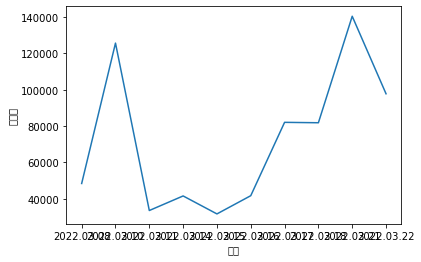

In [117]:
draw_line(df_recent_data, "현대이지웰", "거래량")

In [2]:
import pandas as pd
import datetime

# base_delete_dt = (datetime.datetime.now() - datetime.timedelta(days=10)).strftime("%Y-%m-%d")

# dt = datetime.datetime.now().strftime("%Y-%m-%d")
# df_day_summary = pd.read_csv("./csv/bs_analysis/day_summary.csv", encoding="utf-8-sig")

# # df_day_summary[df_day_summary["DT"] < base_dt].drop(axis=0)
# df_day_summary.drop(df_day_summary.index[df_day_summary["DT"] < base_dt], inplace = True)


In [10]:
url = f"https://finance.naver.com/item/sise.naver?code=372910"
list_df = pd.read_html(url, encoding="euc-kr")

remain_sell = list_df[3].iloc[0][0]
remain_buy = list_df[3].iloc[0][2]

df_deal_summary = list_df[1]

df_deal_summary

,0,1,2,3
0,현재가,7230,매도호가,7250
1,전일대비,상승 70,매수호가,7230
2,등락률(%),+0.98%,전일가,7160
3,거래량,142903,시가,7160
4,거래대금(백만),1040,고가,7460
5,액면가,200원,저가,7160
6,NaN,NaN,NaN,NaN
7,상한가,9300,전일상한,9340
8,하한가,5020,전일하한,5040
9,PER,36.89,EPS,196


In [19]:
df_deal_summary = list_df[1]

dict_deal_sumamry = {}

for idx in [3, 4, 5, 10]:
    dict_deal_sumamry[df_deal_summary.iloc[idx][2]] = df_deal_summary.iloc[idx][3]
    if idx == 10:
        dict_deal_sumamry[df_deal_summary.iloc[idx][0]] = df_deal_summary.iloc[idx][1]

dict_deal_sumamry

{'시가': '7160', '고가': '7460', '저가': '7160', '52주 최저': '6260', '52주 최고': '17600'}

In [28]:
end_prc = 8590
# 전일 시가대비 종가 비율
start_prc = dict_deal_sumamry["시가"]
vs_start_prc = round(end_prc / int(start_prc) * 100, 2)
# 전일 고가대비 종가 비율
high_prc = dict_deal_sumamry["고가"]
vs_high_prc = round(end_prc / int(high_prc) * 100, 2)
# 전일 저가대비 종가 비율
low_prc = dict_deal_sumamry["저가"]
vs_low_prc = round(end_prc / int(low_prc) * 100, 2)
# 신저가대비 종가 비율
lowest_prc = dict_deal_sumamry["52주 최저"]
vs_lowest_prc = round(end_prc / int(lowest_prc) * 100, 2)
# 신고가대비 종가 비율
highest_prc = dict_deal_sumamry["52주 최고"]
vs_highest_prc = round(end_prc / int(highest_prc) * 100, 2)

print(vs_start_prc, vs_high_prc, vs_highest_prc, vs_low_prc, vs_lowest_prc)

119.97 115.15 48.81 119.97 137.22


In [42]:
# 종가 위치(비율) 추출
def split_prc_from_dict_summary(dict_base_prc, end_prc):
    # 전일 시가대비 종가 비율
    start_prc = dict_base_prc["시가"]
    vs_start_prc = round(end_prc / int(start_prc) * 100, 2)
    # 전일 고가대비 종가 비율
    high_prc = dict_base_prc["고가"]
    vs_high_prc = round(end_prc / int(high_prc) * 100, 2)
    # 전일 저가대비 종가 비율
    low_prc = dict_base_prc["저가"]
    vs_low_prc = round(end_prc / int(low_prc) * 100, 2)
    # 신저가대비 종가 비율
    lowest_prc = dict_base_prc["52주 최저"]
    vs_lowest_prc = round(end_prc / int(lowest_prc) * 100, 2)
    # 신고가대비 종가 비율
    highest_prc = dict_base_prc["52주 최고"]
    vs_highest_prc = round(end_prc / int(highest_prc) * 100, 2)

    return [vs_start_prc, vs_high_prc, vs_highest_prc, vs_low_prc, vs_lowest_prc]

In [189]:
def get_end_prc_position(df_base):
    
    def split_prc_from_dict_summary(dict_base_prc):
        list_prc = []
        for val in dict_base_prc.values():
            list_prc.append(val)

        return list_prc
    
    
    list_prc = df_base["DAY_SUMMARY"].apply(lambda X: split_prc_from_dict_summary(X)).to_list()[0]

    dict_cols = {}
    dict_cols["START_PRC"] = int(list_prc[0])
    dict_cols["HIGH_PRC"] = int(list_prc[1])
    dict_cols["HIGHEST_PRC"] = int(list_prc[2])
    dict_cols["LOW_PRC"] = int(list_prc[3])
    dict_cols["LOWEST_PRC"] = int(list_prc[4])

    return pd.Series(dict_cols, index=["START_PRC", "HIGH_PRC", "HIGHEST_PRC", "LOW_PRC", "LOWEST_PRC"])
    

In [192]:
df_dict = pd.DataFrame(data = [["001234", 9990, dict_deal_sumamry], ["005930", 8590, dict_deal_sumamry],], columns=["CD", "END_PRC", "DAY_SUMMARY"])

df_dict = df_dict.groupby(["CD", "END_PRC"]).apply(get_end_prc_position)
df_dict = df_dict.reset_index()

df_dict["VS_START_PRC"] = round((df_dict["START_PRC"] / df_dict["END_PRC"]) * 100, 2)
df_dict["VS_HIGH_PRC"] = round((df_dict["HIGH_PRC"] / df_dict["END_PRC"]) * 100, 2)
df_dict["VS_HIGHEST_PRC"] = round((df_dict["HIGHEST_PRC"] / df_dict["END_PRC"]) * 100, 2)
df_dict["VS_LOW_PRC"] = round((df_dict["LOW_PRC"] / df_dict["END_PRC"]) * 100, 2)
df_dict["VS_LOWEST_PRC"] = round((df_dict["LOWEST_PRC"] / df_dict["END_PRC"]) * 100, 2)

df_dict[["CD", "END_PRC", "VS_START_PRC", "VS_HIGH_PRC", "VS_HIGHEST_PRC", "VS_LOW_PRC", "VS_LOWEST_PRC"]]

,CD,END_PRC,VS_START_PRC,VS_HIGH_PRC,VS_HIGHEST_PRC,VS_LOW_PRC,VS_LOWEST_PRC
0,001234,9990,71.67,74.67,71.67,62.66,176.18
1,005930,8590,83.35,86.85,83.35,72.88,204.89


In [66]:
for val in dict_deal_sumamry.values():
    print(val)

7160
7460
7160
6260
17600


In [132]:
df_pre = pd.read_csv("./csv/day_summary.csv", encoding="utf-8-sig")
# df_pre[df_pre["DT"] == "2022-03-20"].drop(axis=1, inplace=True)
df_pre.drop(df_pre.loc[df_pre['DT'] == "2022-03-20"].index, inplace=True)

df_pre.to_csv("./csv/day_summary.csv", encoding="utf-8-sig", index=False)

In [111]:
str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]

'2019.12'

In [193]:
# 리스트의 평균 추출
def get_avg_in_list(col, last_value=False):
    try:
        list_val = eval(col)
    except:
        list_val = col

    # 리스트의 마지막 값 추출
    if last_value:
        return list_val[-1]
    else:
        return round(statistics.mean(list_val), 2)

In [200]:
df_selected = pd.read_csv("/Users/etlers/src_codes/quant/bs_analysis/pre_targeting_20220325.csv", encoding="utf-8-sig")
df_selected["REMAIN_DEAL"] = df_selected["REMAIN_DEAL"].apply(lambda X: get_avg_in_list(X, last_value=True))
# df_result = df_selected[["종목", "최근 외국인 지분율", "최근 종가", "최근10일 종가 중간값", "ROE 평균", "매수대기"]]

df_selected[df_selected["NM"] == "LG이노텍"][["NM", "REMAIN_DEAL"]]

,NM,REMAIN_DEAL
15,LG이노텍,2953.0


In [10]:
import pandas as pd
import requests
import datetime

now_dt = datetime.datetime.now().strftime("%Y.%m.%d")
    
headers = {
    "referer" : f"https://finance.naver.com/marketindex/exchangeDetail.naver?marketindexCd=FX_USDKRW",    
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" 
}

url = f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}"
res = requests.get(url=url, headers=headers)      
# Pandas : read_html() > table element 추출 가능
df_data = pd.read_html(res.text)[0].dropna().set_index("날짜").reset_index()

# df_data['전일비'] = df_data.종가.diff(-1).fillna(0).astype(int)
df_data[df_data["날짜"] < now_dt].head(1)["종가"].unique()[0]

66100.0

In [44]:
now_dt = datetime.datetime.now().strftime("%Y.%m.%d")

url_currency = "https://finance.naver.com//marketindex/exchangeDailyQuote.naver?marketindexCd=FX_USDKRW"
headers = {
    "referer" : url_currency,    
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" 
}

url = url_currency
res = requests.get(url=url, headers=headers)
df_data = pd.read_html(res.text)[0]
# df_data = pd.read_html(res.text)[0].dropna().set_index("날짜").reset_index()
# preday_currency = df_data[df_data["날짜"]< now_dt].head(1)["매매기준율"]
# preday_currency

In [45]:
df_data[df_data["날짜"]["날짜"] < now_dt]["매매기준율"].head(1)["매매기준율"].unique()[0]

1254.5